# Package

In [1]:
import time
import os
from copy import deepcopy 

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.utils import shuffle, resample
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = (20, 15)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

# Hyperparameters

In [3]:
N_FOLD = 5
EX_PRED = 0

# Data Preparation

## loading

In [4]:
# Load data
l = np.load("./data/CO2_LSTM_T144_I10 min.npz")

# See what's in here
print (l.files)

# get data
rnn_input = l["inputs"]
rnn_label = l["labels"]

MINS = l["mins"]
MAXS = l["maxs"]

LABELMINS = l["labelmins"]
LABELMAXS = l["labelmaxs"]

TIME_STEPS = l["timesteps"]
OUTPUT_SIZE = l["outputsize"]

START_OUTPUT = pd.DatetimeIndex(l["start_output"])
START_INPUT = pd.DatetimeIndex(l["start_input"])
END_OUTPUT = pd.DatetimeIndex(l["end_output"])
END_INPUT = pd.DatetimeIndex(l["end_input"])
INTERVAL = pd.Timedelta(str(l["interval"]))

#EXPLANATION = str(l["explanation"])
EXPLANATION = "CO2_LSTM" + "_T" + str(TIME_STEPS) + "_I" + str(l["interval"])

['maxs', 'outputsize', 'labelmins', 'timesteps', 'mins', 'labelmaxs', 'start_output', 'labels', 'explanation', 'inputs', 'interval', 'start_input', 'end_input', 'end_output']


In [5]:
EXPLANATION

'CO2_LSTM_T144_I10 min'

## Separating

In [6]:
print("time steps: %d, " % TIME_STEPS, end="")
print("output size: %d" % OUTPUT_SIZE)
print("Number of data: %d" % len(rnn_label))

time steps: 144, output size: 12
Number of data: 87252


In [7]:
N_DATA = len(rnn_label)
RATIO = 0.3
N_TEST = int(np.trunc(N_DATA*RATIO))
FOLD_INTERVAL = int(np.trunc((N_DATA - N_TEST)/(N_FOLD - 1)))

print("%d-fold validation setting" % N_FOLD)
print("Test ratio: %.2f\nNumber of test: %d\nFolding interval: %d" % (RATIO, N_TEST, FOLD_INTERVAL))

5-fold validation setting
Test ratio: 0.30
Number of test: 26175
Folding interval: 15269


In [8]:
rnn_label = np.squeeze(rnn_label)

In [9]:
pred_indexs = []
    
for i in range(N_FOLD):
    pred_indexs.append(FOLD_INTERVAL*i)

In [10]:
pred_inputs = []
pred_labels = []
rnn_inputs = []
rnn_labels = []

pred_input_index = []
pred_label_index = []

i = 0

for pred_index in pred_indexs[:-1]:
    pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
    pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])
    
    pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
    pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])
    
    pred_inputs.append(pred_input)
    pred_labels.append(pred_label)

    rnn_inputs.append(rnn_input)
    rnn_labels.append(rnn_label)
    rnn_inputs[i] = np.delete(rnn_inputs[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    rnn_labels[i] = np.delete(rnn_labels[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    i += 1

pred_index = pred_indexs[-1]
pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])

pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])

pred_inputs.append(pred_input)
pred_labels.append(pred_label)

rnn_inputs.append(rnn_input)
rnn_labels.append(rnn_label)
rnn_inputs[-1] = rnn_inputs[-1][:pred_index]
rnn_labels[-1] = rnn_labels[-1][:pred_index]

In [11]:
for i in range(N_FOLD):
    rnn_inputs[i], rnn_labels[i] = shuffle(rnn_inputs[i], rnn_labels[i])

In [12]:
print("Data is ready.")

Data is ready.


In [13]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

# Training & Plotting

1 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.170262, best: 0.000
Training Acc: 0.498, Test Acc: 0.495
-31.86567057880085
Epoch:      500/   50000 cost: 1.236542, best: 0.000
Training Acc: 0.680, Test Acc: 0.483
0.6319921268939456
Epoch:     1001/   50000 cost: 1.536261, best: 0.590 *Best value was replaced.
0.6319921268939456
Epoch:     1000/   50000 cost: 1.536261, best: 0.590
Training Acc: 0.756, Test Acc: 0.590
0.6821224937230822
Epoch:     1003/   50000 cost: 1.537228, best: 0.591 *Best value was replaced.
0.6821224937230822
Epoch:     1063/   50000 cost: 1.570687, best: 0.591 *Best value was replaced.
0.6821224937230822
Epoch:     1064/   50000 cost: 1.571213, best: 0.592 *Best value was replaced.
0.6821224937230822
Epoch:     1066/   50000 cost: 1.572461, best: 0.593 *Best value was replaced.
0.6821224937230822
Epoch:     1067/   50000 cost: 1.573061, best: 0.594 *Best value was replaced.
0.6821224937230822
Epoch:     1068/   50000 cost: 1.5735

Epoch:     5397/   50000 cost: 3.623895, best: 0.702 *Best value was replaced.
0.7176347853050656
Epoch:     5500/   50000 cost: 3.669045, best: 0.702
Training Acc: 0.823, Test Acc: 0.665
0.7062330103721531
Epoch:     5544/   50000 cost: 3.686261, best: 0.705 *Best value was replaced.
0.7062330103721531
Epoch:     6000/   50000 cost: 3.870032, best: 0.705
Training Acc: 0.806, Test Acc: 0.652
0.6912236132677401
Epoch:     6194/   50000 cost: 3.951183, best: 0.708 *Best value was replaced.
0.6912236132677401
Epoch:     6211/   50000 cost: 3.957748, best: 0.713 *Best value was replaced.
0.6912236132677401
Epoch:     6459/   50000 cost: 4.061722, best: 0.718 *Best value was replaced.
0.6912236132677401
Epoch:     6460/   50000 cost: 4.062180, best: 0.723 *Best value was replaced.
0.6912236132677401
Epoch:     6500/   50000 cost: 4.077274, best: 0.723
Training Acc: 0.824, Test Acc: 0.681
0.7192991665800648
Epoch:     7000/   50000 cost: 4.274639, best: 0.723
Training Acc: 0.829, Test Acc: 0

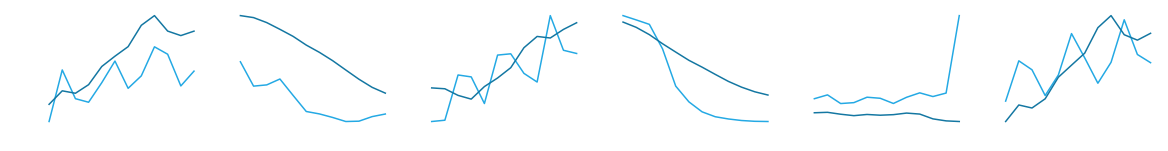

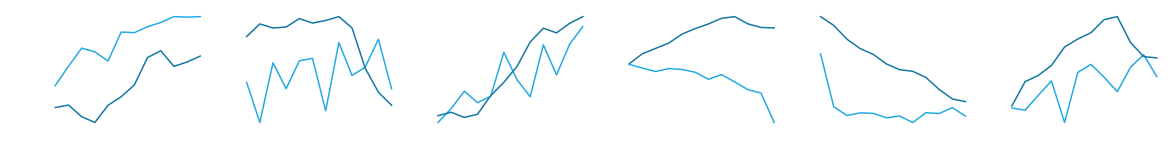

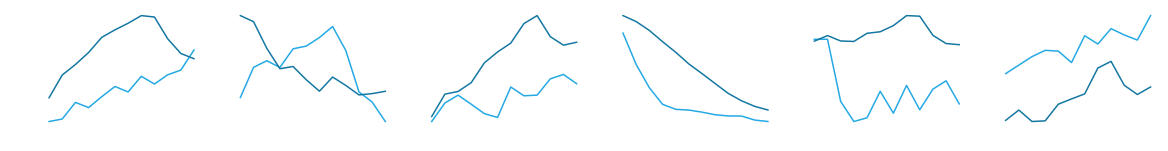

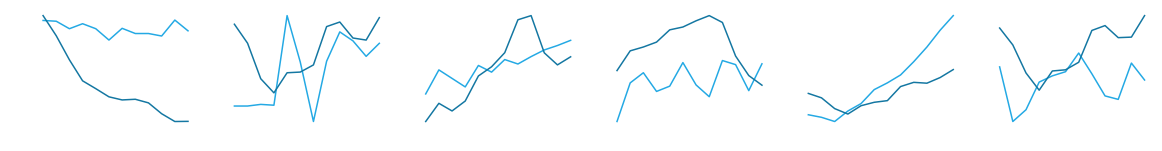

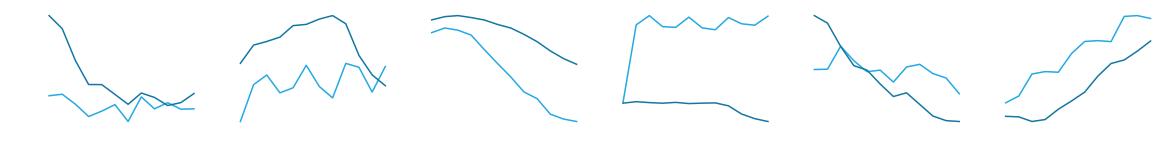

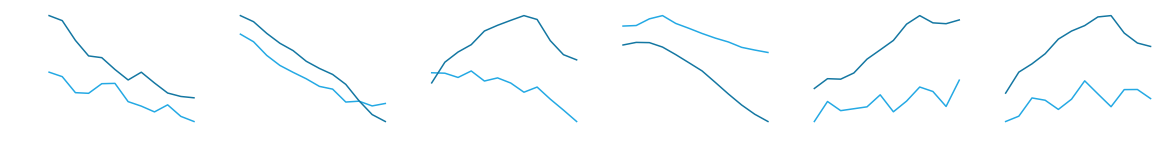

2 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.115881, best: 0.000
Training Acc: 0.491, Test Acc: 0.494
-50.63741047029735
Epoch:      500/   50000 cost: 1.182024, best: 0.000
Training Acc: 0.760, Test Acc: 0.702
0.6325940785890438
Epoch:     1001/   50000 cost: 1.583148, best: 0.750 *Best value was replaced.
0.6325940785890438
Epoch:     1000/   50000 cost: 1.583148, best: 0.750
Training Acc: 0.816, Test Acc: 0.750
0.7138152806500465
Epoch:     1002/   50000 cost: 1.583976, best: 0.751 *Best value was replaced.
0.7138152806500465
Epoch:     1014/   50000 cost: 1.592717, best: 0.760 *Best value was replaced.
0.7138152806500465
Epoch:     1015/   50000 cost: 1.593529, best: 0.760 *Best value was replaced.
0.7138152806500465
Epoch:     1016/   50000 cost: 1.594471, best: 0.762 *Best value was replaced.
0.7138152806500465
Epoch:     1017/   50000 cost: 1.595859, best: 0.765 *Best value was replaced.
0.7138152806500465
Epoch:     1055/   50000 cost: 1.6236

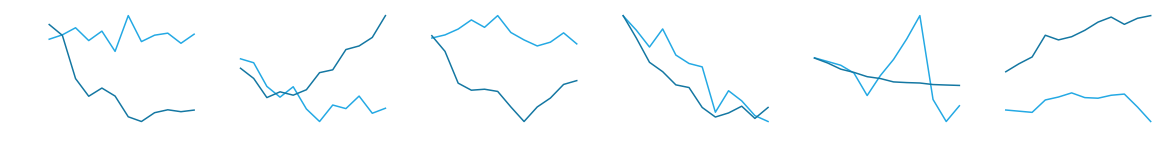

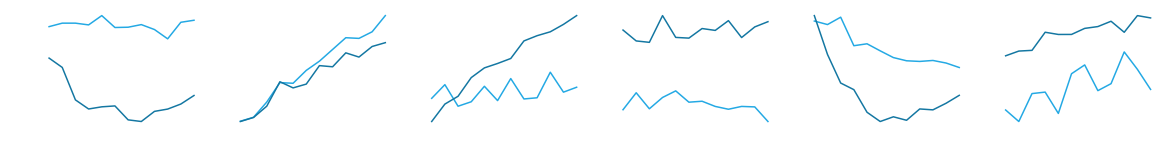

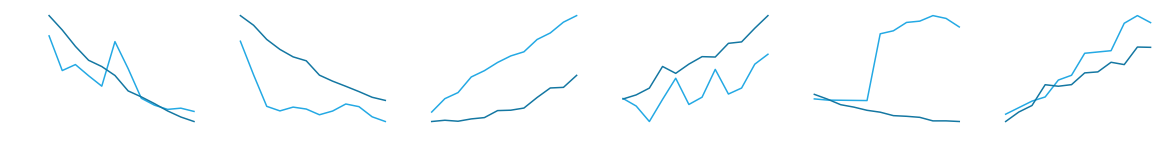

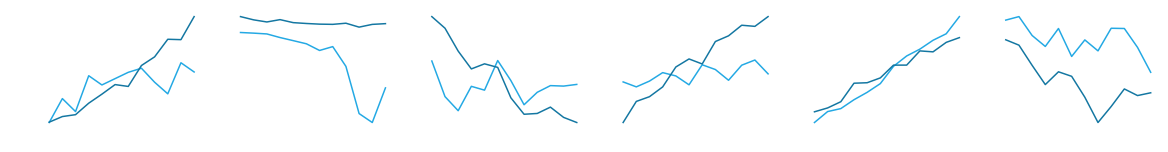

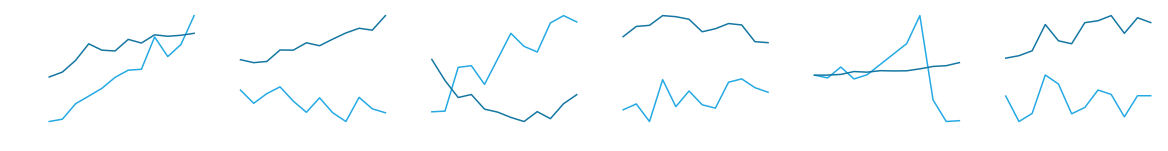

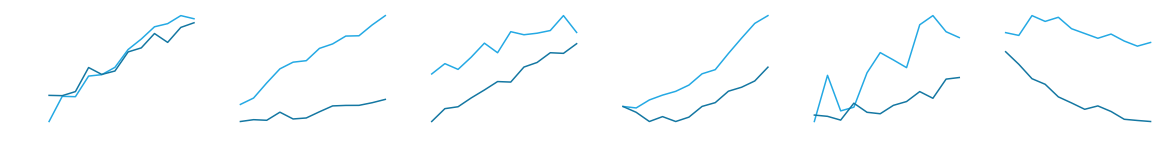

3 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.139692, best: 0.000
Training Acc: 0.494, Test Acc: 0.494
-32.531896657229716
Epoch:      500/   50000 cost: 1.030790, best: 0.000
Training Acc: 0.814, Test Acc: 0.687
0.649318118732766
Epoch:     1000/   50000 cost: 1.354188, best: 0.000
Training Acc: 0.829, Test Acc: 0.711
0.6608044555121311
Epoch:     1003/   50000 cost: 1.355382, best: 0.720 *Best value was replaced.
0.6608044555121311
Epoch:     1006/   50000 cost: 1.357636, best: 0.721 *Best value was replaced.
0.6608044555121311
Epoch:     1010/   50000 cost: 1.360826, best: 0.721 *Best value was replaced.
0.6608044555121311
Epoch:     1013/   50000 cost: 1.363143, best: 0.725 *Best value was replaced.
0.6608044555121311
Epoch:     1023/   50000 cost: 1.368166, best: 0.728 *Best value was replaced.
0.6608044555121311
Epoch:     1025/   50000 cost: 1.369356, best: 0.728 *Best value was replaced.
0.6608044555121311
Epoch:     1026/   50000 cost: 1.3702

Epoch:    19500/   50000 cost: 10.306316, best: 0.796
Training Acc: 0.879, Test Acc: 0.764
0.7394979776938871
Epoch:    20000/   50000 cost: 10.524701, best: 0.796
Training Acc: 0.876, Test Acc: 0.773
0.7466635622618374
Epoch:    20500/   50000 cost: 10.749775, best: 0.796
Training Acc: 0.872, Test Acc: 0.780
0.7503460864765827
Epoch:    21000/   50000 cost: 10.958312, best: 0.796
Training Acc: 0.882, Test Acc: 0.771
0.7381736065511371
Epoch:    21500/   50000 cost: 11.183042, best: 0.796
Training Acc: 0.865, Test Acc: 0.750
0.7387760825721282
Epoch:    22000/   50000 cost: 11.412374, best: 0.796
Training Acc: 0.879, Test Acc: 0.758
0.732403186389913
Epoch:    22500/   50000 cost: 11.624177, best: 0.796
Training Acc: 0.887, Test Acc: 0.772
0.7416383479972097
Epoch:    23000/   50000 cost: 11.843491, best: 0.796
Training Acc: 0.885, Test Acc: 0.753
0.745452741742111

Early stopping.
Epoch:    23444/   50000 cost: 12.039990, best: 0.796
Training Acc: 0.885, Test Acc: 0.773
Optimization F

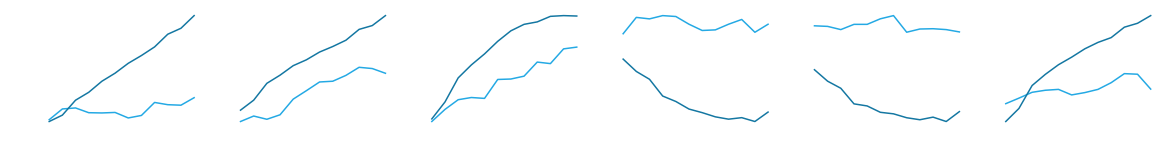

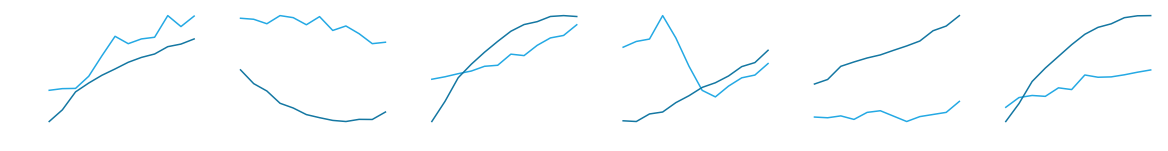

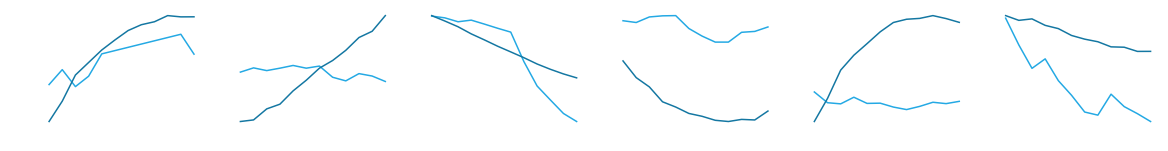

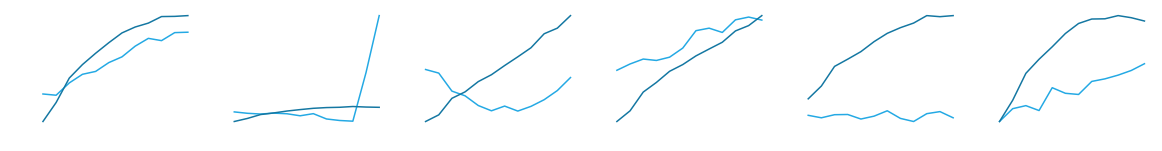

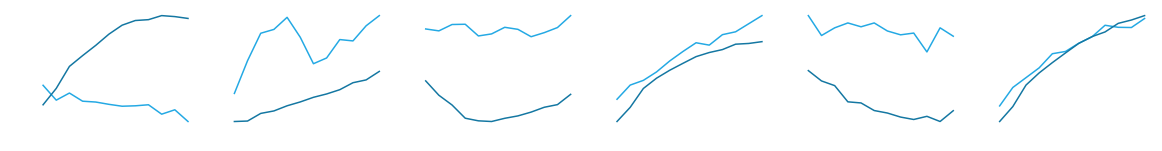

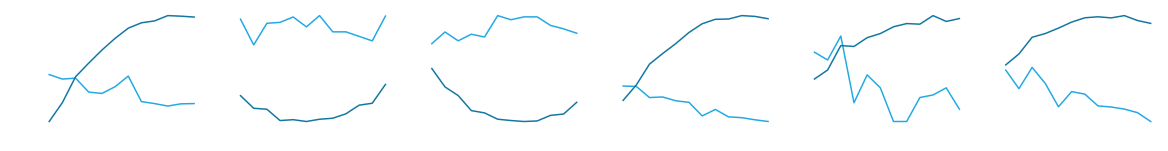

4 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.190635, best: 0.000
Training Acc: 0.494, Test Acc: 0.497
-86.91217683771083
Epoch:      500/   50000 cost: 1.284013, best: 0.000
Training Acc: 0.815, Test Acc: 0.634
0.5756080130004061
Epoch:     1000/   50000 cost: 1.625153, best: 0.000
Training Acc: 0.841, Test Acc: 0.664
0.5831388584954634
Epoch:     1003/   50000 cost: 1.626651, best: 0.667 *Best value was replaced.
0.5831388584954634
Epoch:     1055/   50000 cost: 1.660679, best: 0.671 *Best value was replaced.
0.5831388584954634
Epoch:     1069/   50000 cost: 1.669012, best: 0.673 *Best value was replaced.
0.5831388584954634
Epoch:     1070/   50000 cost: 1.670022, best: 0.674 *Best value was replaced.
0.5831388584954634
Epoch:     1117/   50000 cost: 1.697927, best: 0.674 *Best value was replaced.
0.5831388584954634
Epoch:     1118/   50000 cost: 1.698576, best: 0.675 *Best value was replaced.
0.5831388584954634
Epoch:     1120/   50000 cost: 1.7002

Epoch:    16000/   50000 cost: 16.038884, best: 0.746
Training Acc: 0.453, Test Acc: 0.310
0.23628907287193726
Epoch:    16500/   50000 cost: 17.109351, best: 0.746
Training Acc: 0.456, Test Acc: 0.294
0.28657456594931713
Epoch:    17000/   50000 cost: 18.140504, best: 0.746
Training Acc: 0.461, Test Acc: 0.272
0.3411876050363411
Epoch:    17500/   50000 cost: 19.135258, best: 0.746
Training Acc: 0.476, Test Acc: 0.346
0.17528998390273784
Epoch:    18000/   50000 cost: 20.127222, best: 0.746
Training Acc: 0.492, Test Acc: 0.322
0.31926903574545484

Early stopping.
Epoch:    18364/   50000 cost: 20.807772, best: 0.746
Training Acc: 0.495, Test Acc: 0.294
Optimization Finished
training time: 10041.02 sec.
INFO:tensorflow:Restoring parameters from ./models/best_trained_CO2_LSTM_T144_I10 min_F4.ckpt
Testing Accuracy: 0.74593836
Chronological graphs for fold # 4.


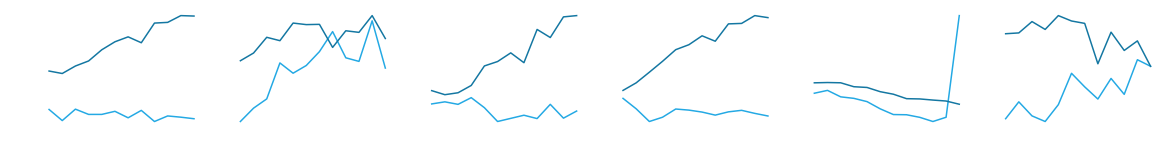

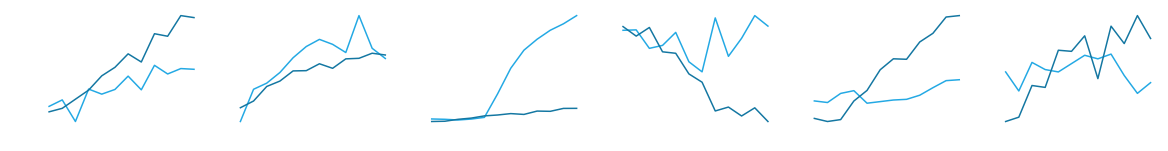

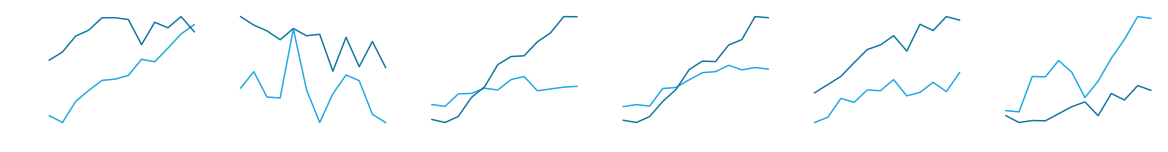

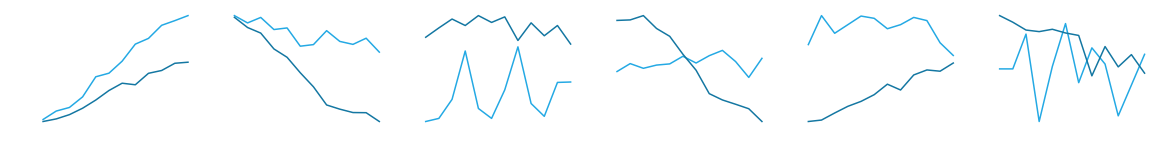

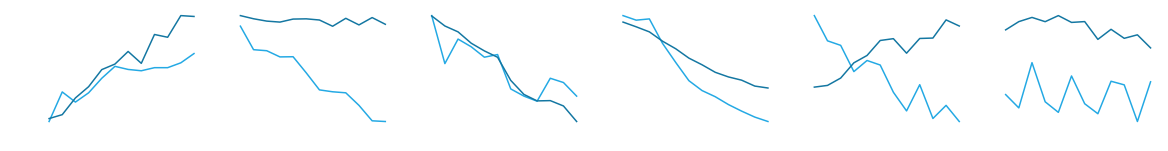

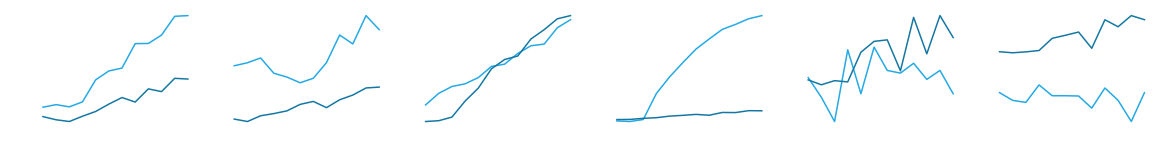

5 for started.
networks are ready
seesion start
Epoch:        0/   50000 cost: 0.095161, best: 0.000
Training Acc: 0.489, Test Acc: 0.496
-72.59026453586844
Epoch:      500/   50000 cost: 1.120413, best: 0.000
Training Acc: 0.755, Test Acc: 0.791
0.6331375737467174
Epoch:     1001/   50000 cost: 1.585459, best: 0.860 *Best value was replaced.
0.6331375737467174
Epoch:     1000/   50000 cost: 1.585459, best: 0.860
Training Acc: 0.784, Test Acc: 0.860
0.8126589332645361
Epoch:     1024/   50000 cost: 1.604138, best: 0.865 *Best value was replaced.
0.8126589332645361
Epoch:     1167/   50000 cost: 1.730794, best: 0.867 *Best value was replaced.
0.8126589332645361
Epoch:     1247/   50000 cost: 1.803248, best: 0.868 *Best value was replaced.
0.8126589332645361
Epoch:     1500/   50000 cost: 2.010891, best: 0.868
Training Acc: 0.797, Test Acc: 0.850
0.8201673049666415
Epoch:     2000/   50000 cost: 2.418591, best: 0.868
Training Acc: 0.786, Test Acc: 0.744
0.601245373209074
Epoch:     2500/

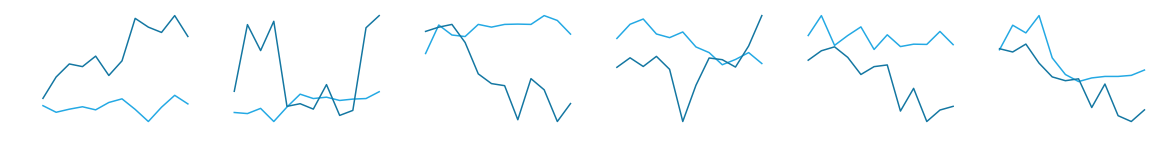

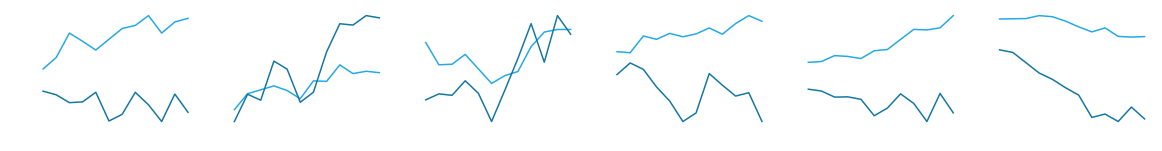

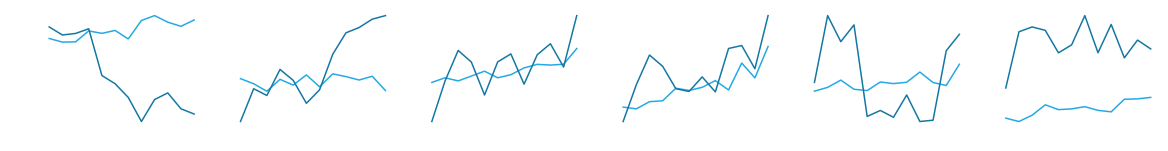

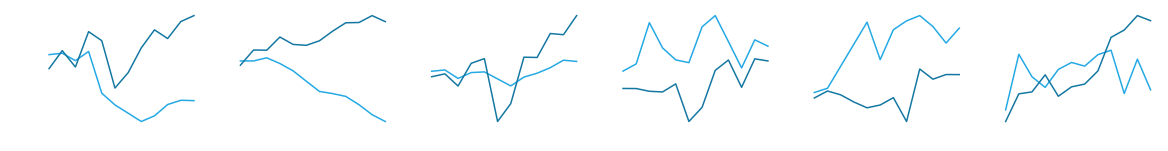

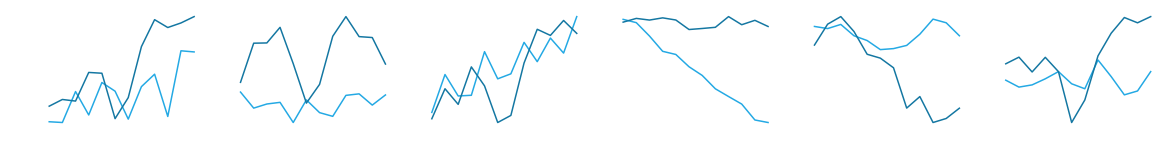

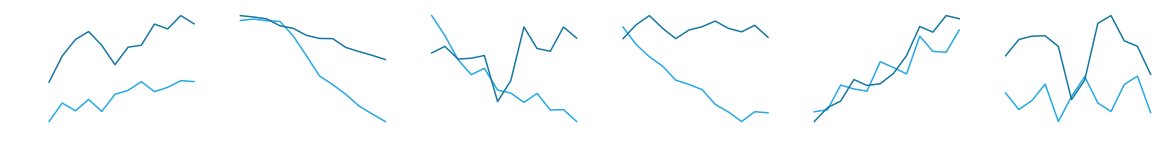

All fold vaildation were ended.
5-fold validation accuracy: 0.792


In [14]:
accuracies = []
for i in range(N_FOLD):
    
    pred_input = pred_inputs[i]
    pred_label = pred_labels[i]
    
    rnn_input = rnn_inputs[i]
    rnn_label = rnn_labels[i]

    print("%d for started." % (i+1))
    # Parameters
    EXPLANATION_F = EXPLANATION + "_F" + str(i+1)
    LIMIT = 3002
    SHIELD = 999
    
    global_step = tf.Variable(0, trainable=False)    
    LEARNING_RATE = tf.train.exponential_decay(0.035, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.0001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 24
    DROP_PROB = 0.9
    BATCH_SIZE =  512
    DISPLAY_STEP = 500

    N_INPUT = rnn_input[0].shape[1]
    N_OUTPUT = rnn_label[0].shape[0]

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    
    # Define weights
    weights = tf.get_variable(EXPLANATION_F[-2:] + "wgt", shape=[N_HIDDEN, N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(EXPLANATION_F[-2:] + "bias", shape=[N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)    
    
    
    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)

        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation

    pred = RNN(x, weights, biases, drop_prob)

    print("networks are ready")
    
    # Define loss and optimizer
    cost =  tf.losses.mean_squared_error(labels=y, predictions=pred)
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon = EPSILON).minimize(cost)
    tf.summary.scalar('cost', cost)
    
    # Evaluate model
    ymean = tf.reduce_mean(y)
    SSE = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    SSR = tf.reduce_sum(tf.square(tf.subtract(pred, ymean)))
    r_squared = SSR/(SSE+SSR)

    accuracy = r_squared
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()
    
    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/open_" + "F"+ str(i+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/open_" + "F"+ str(i+1))
    sess.run(init)

    print("seesion start")
    
    
    
    # Launch the graph
    best_pred_acc = EX_PRED
    ex_pred_acc = 0
    avg_cost = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()

    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB})
        train_writer.add_summary(summary, EPOCH)
        avg_cost += sess.run(cost, feed_dict={x: batch_x, y: batch_y, drop_prob: 1.0})
        summary, pred_acc = sess.run([merged, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
        test_writer.add_summary(summary, EPOCH)
        if pred_acc > ex_pred_acc:
            if EPOCH <= SHIELD:
                pass
            elif pred_acc > best_pred_acc:
                bestpath = "./models/best_trained_" + EXPLANATION_F + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_acc = pred_acc
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, avg_cost, best_pred_acc))
                print(r2_score(pred_label, R2))
        else:
            early_stop_buffer += 1

        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_acc = pred_acc
            
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, avg_cost, best_pred_acc))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            print(r2_score(pred_label, R2))

    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, avg_cost, best_pred_acc))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))
    
    
    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION_F + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0})
    accuracies.append(final_acc)
    print ("Testing Accuracy:", final_acc)
    training_result = sess.run(pred, feed_dict={x: rnn_input, drop_prob: 1.0})
    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0})
    #Chronol
    print("Chronological graphs for fold # %d." % (i+1))
    x_t = np.arange(0, OUTPUT_SIZE)

    for _ in range (6):

        NUMBERS = np.arange(1, prediction.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 661

        for NUMBER in NUMBERS:

            fig = plt.subplot(position)
            measured1 = plt.plot(x_t, pred_label[NUMBER, :], c=cmap_m[5]) #estimated
            expect1 = plt.plot(x_t, prediction[NUMBER, :], c=cmap[5]) #estimated
            fig.axis('off')

            position += 1
        plt.show()
        _ += 1
    training_result = (training_result * (LABELMAXS - LABELMINS)) + LABELMINS
    training_label = (rnn_label * (LABELMAXS - LABELMINS)) + LABELMINS
    prediction = (prediction * (LABELMAXS - LABELMINS)) + LABELMINS
    pred_label = (pred_label * (LABELMAXS - LABELMINS)) + LABELMINS
    training_result_csv = pd.DataFrame(training_result)
    training_label_csv = pd.DataFrame(training_label)
    prediction_csv = pd.DataFrame(prediction, index=pred_label_index[i])
    pred_label_csv = pd.DataFrame(pred_label, index=pred_label_index[i])
    
    if not os.path.isdir("./results/"):
        os.makedir("./results/")
    training_result_csv.to_csv("./results/" + "train_rs" + EXPLANATION_F + ".CSV")
    training_label_csv.to_csv("./results/" + "train_lb" + EXPLANATION_F + ".CSV")
    prediction_csv.to_csv("./results/" + "output_" + EXPLANATION_F + ".CSV")
    pred_label_csv.to_csv("./results/" + "labels_" + EXPLANATION_F + ".CSV")
    
    tf.reset_default_graph()
    sess.close()
    
print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))